# Exercise 0 - Installation

This exercise is to be introduced during tutorial 1.

The purpose of this exercise is to test out EnergyPlus on your computer, ensure all Python packages are working correctly and that as many bugs have been eliminated before we start using this tool in earnest beginning in Week 4. There is no expectation for you to understand every step in this notebook at this point.


I will use the following colour codes throughout the module to emphasize information for the student.

### Colour codes

<span style="color:orange;"> Orange text is for emphasis and definitions </span>

<span style="color:lime;"> Green text is for tasks to be completed by the student </span>

<span style="color:dodgerblue;"> Blue text is for Python coding tricks and references </span>

Please look out for them when going through the code.


## Load all the necessary Python packages
<span style="color:orange"> All packages should work with Conda environment if installed on your machine. Otherwise all necessary packages can be installed in a virtual environment (.venv) in VS Code using: Ctrl+Shift+P > Python: Create Environment > Venv > Python 3.12.x > requirements.txt </span>

In [13]:
from src.runEnergyPlus import run_energyPlus
from src.sampling import randomSampling
from src.processResults import processHourlyResults, processResilienceResults


import json
import matplotlib.pyplot as plt

from multiprocessing import Pool
import os
import pandas as pd
from pathlib import Path
import time


In [14]:
! pip install scikit-optimize

## 1. Getting Started
### 1.1 Enter the general parameters for this run.

<span style="color:limegreen">This cell contains all of the options you need to manually input for this exercise.<span>


In [15]:
# Enter a save name for this run
saveName = "Exercise_0"

# Enter the path to the directory with your EnergyPlus executable. Enter the full path separated by commas.
#NOTE: Need to use Pathlib:Path to enter the absolute path to avoid issues cross-platform compatibility issues.
#NOTE: Enter each sub-directory as a tuple separated by commas. Note special characters required for drive letters

from pathlib import Path

ep_dir = Path("/Users", "rf", "Documents", "EnergyPlus-25-1-0")

#ep_dir = Path("c:\\", "EnergyPlusV25-1-0") # Example For Windows

# The weather file to be used for this batch of simulations. This file should be located in the src/weatherData/ directory.
weatherFile = "GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw"

# The baseline file to be used for this simulation. This file should be located in the idfs/ directory
idf_file = "1-storey_baseline.idf"

# The parameters file to be used as part of this simulation
parameters_file = "Exercise 0.json"

# The maximum number of simulations to be run
n_simulations = 16


This step creates the full paths for the energyPlus directory, idf file, and weather file and confirms they all exist. Else an exception will be created.

In [16]:
baseline_idf_path = Path("idfs", idf_file)
weather_file_path = Path("weatherData", weatherFile)

if not ep_dir.exists():
    raise Exception (f"Could not find energyPlus executable at {ep_dir}.")
if not baseline_idf_path.exists():
    raise Exception (f"Could not find idf_file at {baseline_idf_path}.")
if not weather_file_path.exists():
    raise Exception (f"Could not find weather_file at {weather_file_path}.")

print (f"The EnergyPlus directory is: {ep_dir}.")
print (f"The baseline idf file is: {baseline_idf_path}.")
print (f"The weather file is: {weather_file_path}.")


The EnergyPlus directory is: /Users/rf/Documents/EnergyPlus-25-1-0.
The baseline idf file is: idfs/1-storey_baseline.idf.
The weather file is: weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw.


## 2. Simulation parameters.
Parameter files are the instructions on how each model will change upon each iteration. These instructions are located in the *simulationParameters/* directory.

The files are in JSON format. JSON files are similar in nature (but not the same) as Python's dictionary and list types.

Putting the instructions in separate files allows us to quickly change and modify the simulation parameters for all the exercises throughout the course.

The below code opens the json file and places into a Python dictionary.

In [17]:
parameters_file_path = Path("simulationParameters", parameters_file)

if not parameters_file_path.exists():
    raise Exception (f"Could not find the parameters_file at {parameters_file_path}.")

with open (parameters_file_path) as f:
    parameters = json.load(f)


In this example we have 13 simulation parameters which are being modified. They are:

In [18]:
print (f"Name                      TYPE        VALUES")
for k,v in parameters.items():
    print (f"{k:<26}{v['type']:<12}{v['values']}")

Name                      TYPE        VALUES
coolingSetpoint           constant    [99]
length                    constant    [10]
width                     int         [5, 10]
height                    float       [3, 4]
u_windows                 int         [1.0, 6.0]
g_value                   float       [0.3, 0.9]
wwr                       float       [0.01, 0.99]
ach_50                    float       [1, 10]
ventilationRate           categorical [0.0, 0.01, 0.02]
slabInsulationThickness   categorical [0.0001, 0.025, 0.05, 0.075, 0.1]
wallInsulationThickness   categorical [0.0001, 0.025, 0.05, 0.075, 0.1]
roofInsulationThickness   categorical [0.0001, 0.025, 0.05, 0.075, 0.1]
fixedShadingDepth         float       [0.01, 1.0]


There are four types of variables that can be chosen:
* constant: A single value that we want fixed for the run
* float: This a two value list of values denoting the minimum and maximum range of values to be sampled from. The values sampled will be floats (decimals)
* int: This a two value list of values denoting the minimum and maximum range of values to be sampled from. The values sampled will be always be integers, even if floats are given in the list.
* categorical: This is a list of any length denoting a limited number of values from which to be sampled from

In the above example the building has a constant length of 10m, a width of between 5 and 10m (integer values only), a height between 3 and 4m (decimal values), and categorical values for insulation in 25 mm (1 inch) increments. (NOTE: that in EnergyPlus, we can not give an insulation thickness of zero. Instead we give a very small value so as to have minimal impacts on the simulation)

## 3. Generating Samples

Lets generate a list of iterations using a random sampling method for each variable. This is done using the randomSampling function. See the function in src/sampling to understand how it works.

Confirm that each variable has been sampled as expected.



In [19]:
# Create a list of combinations of parameters stored in a dataframe format
combinations = randomSampling(parameters, n_simulations)
print (combinations)

# Save the combinations as a csv
savePath = Path("outputs", "combinations", f"combinations_{saveName}.csv")
combinations.to_csv(savePath)
print (f"Combinations dataframe saved to {savePath}.")

    coolingSetpoint  length  width    height  u_windows   g_value       wwr  \
0              99.0    10.0    5.0  3.424550        1.0  0.754450  0.183779   
1              99.0    10.0    7.0  3.012987        2.0  0.895015  0.952432   
2              99.0    10.0    6.0  3.637690        1.0  0.478878  0.933127   
3              99.0    10.0    6.0  3.640772        5.0  0.764074  0.671093   
4              99.0    10.0    9.0  3.549642        3.0  0.416495  0.380450   
5              99.0    10.0    9.0  3.042493        4.0  0.417749  0.765415   
6              99.0    10.0    8.0  3.237114        4.0  0.421719  0.684239   
7              99.0    10.0    7.0  3.870508        3.0  0.616216  0.638154   
8              99.0    10.0    5.0  3.903718        5.0  0.892820  0.732926   
9              99.0    10.0    5.0  3.426547        5.0  0.848304  0.264916   
10             99.0    10.0    5.0  3.508226        4.0  0.507495  0.336208   
11             99.0    10.0    5.0  3.717011        

## 4. Running EnergyPlus simulations in parallel
In these steps we will run the EnergyPlus simulations in parallel using the multiprocessing Pool module. A function called starmap distributes simulations to be run to each thread by calling the runEnergyPlus() function with a tuple of appropriate inputs.

### 4.1 Prepararation
The first step is to prepare the combination dataframe above into the appropriate format to be passed to the runEnergyPlus function().

In [20]:
# The parameters for each iteration need to be put into a list of tuples to pass to the multiprocessing pool starmap function

# First convert the combinations dataframe into a list of dictionaries for each row of the dataframe. Example:
"""
[ 
    {'length': 10.0, 'width': 5.0, 'height': 3.152719, 'u_windows': 2.0},
    {'length': 10.0, 'width': 9.0, 'height': 3.664094, 'u_windows': 3.0},
    {'length': 10.0, 'width': 7.0, 'height': 3.393122, 'u_windows': 1.0},
]
"""
inputs = combinations.to_dict("records")

# Convert the list of dictionaries into a list of tuples
# The ep_dir and idf_path and weather file path need to be part of the tuple as well as an integer i to mark the simulation number.
"""
[ 
    (ep_dir, idf_path, weather_path, {'length': 10.0, 'width': 5.0, 'height': 3.152719, 'u_windows': 2.0}, 0),
    (ep_dir, idf_path, weather_path, {'length': 10.0, 'width': 9.0, 'height': 3.664094, 'u_windows': 3.0}, 1),
    (ep_dir, idf_path, weather_path, {'length': 10.0, 'width': 7.0, 'height': 3.393122, 'u_windows': 1.0}, 2),
]
"""

inputs = [(ep_dir, baseline_idf_path, weather_file_path, inputs[i], i) for i in range(n_simulations)]


### 4.2 Running in Parallel

The second step is to run all the simulations with multiprocessing.

<span style = "color:orange"> NOTE: </span> This step may take some time to finish. A simulation may take between 10 and 20 seconds to run depending on your computer. If you are run 50 simulations on 10 processors in parallel, expect 5 cycles lasting between 10 and 20 seconds --> it may take 50 to 100 seconds to complete.

In [21]:
# Run all of the simulations in parallel
# Set up multiprocessing by first obtaining the number of processors on your machine.
n_processors = os.cpu_count()

print (f"Preparing to run {n_simulations} EnergyPlus simulation in parallel using {n_processors} processors.")

# Set-up the multiprocessing code block with timers
t0 = time.time()
if __name__ == "__main__":
    with Pool(processes = n_processors) as pool:
        returnValues = pool.starmap(run_energyPlus, inputs)
t1 = time.time()
print (f"\nFinished running all {n_simulations} simulations")


# Un pack the results from the batch simulation
returnCodes = [i[0] for i in returnValues]
hourlyResults = [i[1] for i in returnValues]
resilienceResults = [i[2] for i in returnValues]


# Check if any simulations had errors
errors = [x.args for x in returnCodes if x.returncode == 1]
if len(errors) > 0:
    print (f"The following {len(errors)} simulations had errors:")
    for error in errors:
        print (f"\t{error}")
else:
    print (f"All simulations completed successfully in {t1 - t0:.4f} s.")



Preparing to run 16 EnergyPlus simulation in parallel using 10 processors.
Beginning EnergyPlus simulation of iteration 0.
Beginning EnergyPlus simulation of iteration 2.
Beginning EnergyPlus simulation of iteration 1.
Beginning EnergyPlus simulation of iteration 3.
Beginning EnergyPlus simulation of iteration 4.
Beginning EnergyPlus simulation of iteration 5.
Beginning EnergyPlus simulation of iteration 6.
Beginning EnergyPlus simulation of iteration 7.
Beginning EnergyPlus simulation of iteration 8.
Beginning EnergyPlus simulation of iteration 9.
Finished EnergyPlus simulation of iteration 0. Time of simulation = 4.0632 s.
Beginning EnergyPlus simulation of iteration 10.
Finished EnergyPlus simulation of iteration 9. Time of simulation = 4.0936 s.
Beginning EnergyPlus simulation of iteration 11.
Finished EnergyPlus simulation of iteration 5. Time of simulation = 4.1130 s.
Beginning EnergyPlus simulation of iteration 12.
Finished EnergyPlus simulation of iteration 7. Time of simulatio

<span style = "color:orange"> NOTE: </span> If using a Windows machine, progress updates from the run_energyPlus function are unavailable in Jupyter notebooks. You are able to tell if the simulations are running correctly if you see directories called *iteration_n* being generated in the iterations folder. Inside each directory is the energyplus file (.idf) and its results files (.csv).

### 4.3 Collecting Results

The third step is to collect all of the necessary results from the EnergyPlus output files (eplustbl.csv and eplusout.csv).

We define a function called processHourlyResults which will collect all of the data of interest from the EnergyPlus Files. At this preliminary stage, we are just collecting basic energy and indoor temperature data, but there is scope to modify this function and analyze different data from the results file or perform some post-processing.

In [22]:
hourlyResults = []
resilienceResults = []
for i in range(n_simulations):
    # Get the hourly results
    results_path = Path("iterations", f"iteration_{i}", "eplusout.csv")
    hourlyResults.append (processHourlyResults(results_path))

    # Get the resilience metrics results
    results_path = Path("iterations", f"iteration_{i}", "eplustbl.csv")
    resilienceResults.append(processResilienceResults(results_path))


# Putting both the results dictionaries into a dataframe and concatenating them together
df = pd.DataFrame(hourlyResults)
df2 = pd.DataFrame(resilienceResults)

df = pd.concat([df, df2], axis = 1)

# Save the results file as a csv
savePath = Path("outputs", "results", f"results_Exercise_0.csv")
df.to_csv(savePath)

print (f"results dataframe saved to {savePath}.")

results dataframe saved to outputs/results/results_Exercise_0.csv.


Collect the information in a for loop and combine into a dataframe.

## 5. Analyzing the Results
The next step is to analyze the results. Here is a quite snippet plotting two objective functions: *heatingSum* and *temperature>25C* colour-coded by the variable *wwr*.

The nature of the analysis will change week-to-week.

results dataframe saved to outputs/images/Lecture 0_TestImage.svg.


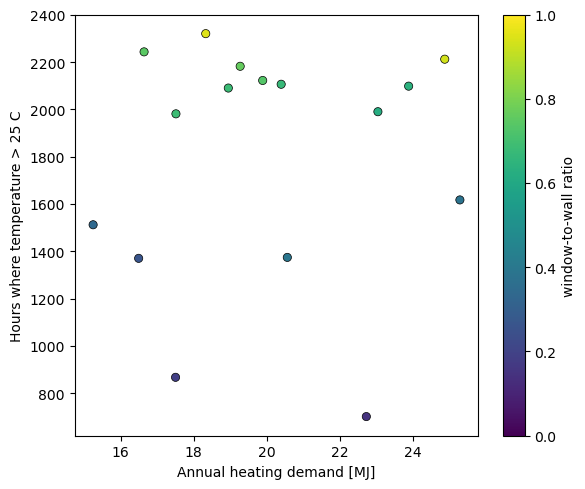

In [23]:
fig, ax = plt.subplots()
scatter = ax.scatter(df["heatingSum"] / 10**9, df["temperature>25C"], s = 35, c = combinations.wwr, vmin = 0, vmax = 1, linewidths = 0.5, edgecolors = "black")

ax.set_xlabel ("Annual heating demand [MJ]")
ax.set_ylabel ("Hours where temperature > 25 C")

cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel("window-to-wall ratio")

fig.set_figwidth(6)
fig.set_figheight(5)
fig.tight_layout()

# Save the file in svg (vector) format
filePath = Path("outputs", "images", "Lecture 0_TestImage.svg")
plt.savefig(filePath, format = "svg")
print (f"results dataframe saved to {filePath}.")

plt.show()


## 6. Conclusion

If all steps have completed correctly you should be good to go for the rest of the term beginning in Week 4. 

You can delete all the contents of the iterations folder.

<span style="color:orange">Be sure to pull the latest updates as course material will be added week-by-week. <span>